In [1]:
import os
import numpy as np
import pandas as pd
import math
import glob
import statistics as stat
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy import stats
from scipy.stats import variation
from scipy.stats import wilcoxon
from scipy.stats import pearsonr
import warnings
from statsmodels.stats.anova import AnovaRM
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import seaborn as sns
import pingouin as pg
import itertools as it
from great_tables import GT, html
# warnings.simplefilter(action='ignore', category=FutureWarning)
# warnings.filterwarnings('ignore')

import typingmod as typ

In [2]:
# Setting save directory
save_dir = r'/Users/rubi/Desktop/Github/typingexp/typing_task_analysis/'\
           'figures/'

In [3]:
def GABA_ID_filter(df):
    filtered = df[df.sID.isin(GABA_sIDs)]
    filtered = filtered.sort_values(by='sID', ascending=True).reset_index(drop=True)
    return filtered

In [4]:
## importing GABA quanitification .csv
## data table is edited to exclude certain data point prior to import
GABA_quant = pd.read_csv(r'/Volumes/greenhouse/MRS/data/Typ_GABA_quant_filtered.csv')
GABA_quant_nofilt = pd.read_csv(r'/Volumes/greenhouse/MRS/data/Typ_GABA_quant.csv')
GABA_sIDs = GABA_quant.sID.unique() ## making list of sIDs with GABA data
df_dir = r'/Users/rubi/Desktop/Github/typingexp/typing_task_analysis/'\
           'dataframes/'

# Importing behavioral metric dataframes. 
file_list = ['iki_metrics_bybf',
            'iki_metrics_bywf',
            'delta_ikis_bybf',
            'delta_ikis_bywf',
            'rts_bywf',
            'delta_rts_bywf',
            'delta_vars_bybf',
            'delta_vars_bywf',
            'indiv_globalmetrics'
            ]

dfs = {}
for file in file_list: 
    df = pd.read_csv(df_dir + file + '.csv', index_col=0)
    df_filtered = GABA_ID_filter(df)
    filename = os.path.basename(file) # Get the filename
    dfs[filename] = df_filtered

In [5]:
# Function that filters task metric dataframe to only include subjects that have 
# usable data for a given voxel
def pearson_filter(df, bf_or_wf, freq_type, metric, sIDs):
    if bf_or_wf != 'global':
        filtered = df[df[bf_or_wf] == freq_type]
    else:
        filtered = df
    filtered_2 = filtered[filtered.sID.isin(sIDs)]
    return filtered_2[['sID', metric]]

# Function that runs pearson correlation between a given task metric and voxel
def pearson_corr(df, bf_or_wf, freq_type, metric, voxel):
    sIDs = GABA_quant[(GABA_quant['voxel'] == voxel) & 
                      (GABA_quant['Mean_GABA_Cr'].isna() == False)].sID.unique()
    task_data = pearson_filter(df,
                               bf_or_wf,
                               freq_type,
                               metric,
                               sIDs)
    mrs_data = GABA_quant[GABA_quant['voxel'] == voxel][['sID', 'Mean_GABA_Cr']].dropna()
    print(metric + " " + bf_or_wf + " " + freq_type + " " + 'vs.' +
          " " + voxel + " " + 'GABA')
    print(pearsonr(task_data[metric], mrs_data['Mean_GABA_Cr']))

# Function that outputs the filtered task and MRS data being compared for 
# figure generation.
def task_vs_mrs_plot(df, bf_or_wf, freq_type, metric, voxel):
    sIDs = GABA_quant[(GABA_quant['voxel'] == voxel) & 
                      (GABA_quant['Mean_GABA_Cr'].isna() == False)].sID.unique()
    task_data = pearson_filter(df,
                               bf_or_wf,
                               freq_type,
                               metric,
                               sIDs)[metric]
    mrs_data = GABA_quant[GABA_quant['voxel'] == voxel]['Mean_GABA_Cr'].dropna()
    return task_data, mrs_data

# SfN Correlations

## Across voxel ANOVA

In [6]:
no_occ = GABA_quant[GABA_quant['voxel'] != 'occ']

nova = pg.rm_anova(GABA_quant, dv='Mean_GABA_Cr', within='voxel', subject='sID', correction=True)
tukey = pg.pairwise_tests(GABA_quant, 'Mean_GABA_Cr', 'voxel', effsize='cohen', padjust='bonf')
print(nova, tukey)

  Source  ddof1  ddof2         F     p-unc  p-GG-corr       ng2       eps  \
0  voxel      4     72  1.367551  0.253727   0.265319  0.055508  0.648559   

   sphericity  W-spher  p-spher  
0        True      inf      1.0     Contrast       A       B  Paired  Parametric         T        dof  \
0    voxel    L_M1  L_thal   False        True  0.890612  26.233935   
1    voxel    L_M1    R_M1   False        True -1.403236  46.000000   
2    voxel    L_M1  R_thal   False        True  1.252623  27.631394   
3    voxel    L_M1     occ   False        True  0.826582  37.211720   
4    voxel  L_thal    R_M1   False        True -1.634286  27.229970   
5    voxel  L_thal  R_thal   False        True  0.144002  37.946564   
6    voxel  L_thal     occ   False        True -0.287958  34.233463   
7    voxel    R_M1  R_thal   False        True  2.116840  28.949416   
8    voxel    R_M1     occ   False        True  1.880516  38.980630   
9    voxel  R_thal     occ   False        True -0.507850  36.947973

/Users/rubi/miniconda3/envs/jlab/lib/python3.12/site-packages/pingouin/distribution.py:1004: RuntimeWarning: divide by zero encountered in scalar divide
  W = np.prod(eig) / (eig.sum() / d) ** d


/var/folders/42/sqkdrmx52wgfnxt8ycz1hhlc0000gn/T/ipykernel_27965/2307502273.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(GABA_quant,
/var/folders/42/sqkdrmx52wgfnxt8ycz1hhlc0000gn/T/ipykernel_27965/2307502273.py:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(voxel_labels)


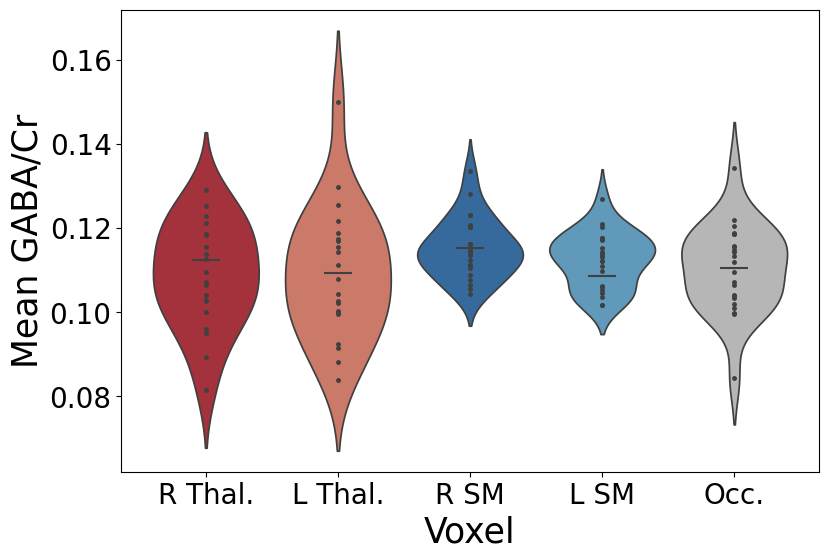

In [49]:
RdBu = sns.color_palette('RdBu', 8)
grey = sns.color_palette('grey')

color_list = [RdBu[0], RdBu[1], RdBu[7], RdBu[6], grey[4]] 
custom_RdBu = sns.color_palette(color_list)

f, ax = plt.subplots(figsize=(9, 6), facecolor='none')
sns.violinplot(GABA_quant, 
                   x='voxel', 
                   y='Mean_GABA_Cr', 
                   order=[ "R_thal", "L_thal", "R_M1", "L_M1", "occ"],
                   # hue='voxel',
                   palette=custom_RdBu, 
                   ax=ax,
                   edgecolor='0.25',
                   inner='point',
                   inner_kws=dict(edgecolor='0.25', color=".25"))

violin_means = GABA_quant.groupby(['voxel']).Mean_GABA_Cr.agg('mean').reset_index()
violin_means = violin_means.sort_values(by="voxel")
sns.scatterplot(x=range(len(violin_means['Mean_GABA_Cr'])), 
                y=violin_means['Mean_GABA_Cr'], 
                color='0.25', ax=ax,
                marker='_', linewidth=1.5, s=400)

ax.set_xlabel("Voxel", fontsize=25)
ax.set_ylabel("Mean GABA/Cr", fontsize=25)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)

voxel_labels=['R Thal.', 'L Thal.', 'R SM', 'L SM', 'Occ.']
ax.set_xticklabels(voxel_labels)


plt.savefig(save_dir + 'GABA_violin_byvoxel.png', dpi=300, bbox_inches='tight')
plt.show()

In [8]:
## Across voxel Pearsons

def calculate_pvalues(df):
    dfcols = pd.DataFrame(columns=df.columns)
    pvalues = dfcols.transpose().join(dfcols, how='outer')
    for r in df.columns:
        for c in df.columns:
            tmp = df[df[r].notnull() & df[c].notnull()]
            pvalues.loc[r, c] = round(pearsonr(tmp[r], tmp[c])[1], 4)
    return pvalues

def vox_filter(voxel):
    DF = GABA_quant[GABA_quant['voxel'] == voxel]['Mean_GABA_Cr'].reset_index(drop = True)
    return DF

data = {
    'R_thal': vox_filter('R_thal'),
    'L_thal': vox_filter('L_thal'),
    'R_M1': vox_filter('R_M1'),
    'L_M1': vox_filter('L_M1'),
    'occ': vox_filter('occ')
}

df = pd.DataFrame(data)

correlation_matrix = df.corr(method='pearson')
print(correlation_matrix)

calculate_pvalues(df)

          R_thal    L_thal      R_M1      L_M1       occ
R_thal  1.000000 -0.248392 -0.255598  0.403013  0.373316
L_thal -0.248392  1.000000 -0.009741  0.088399 -0.014662
R_M1   -0.255598 -0.009741  1.000000  0.113229 -0.195610
L_M1    0.403013  0.088399  0.113229  1.000000  0.204591
occ     0.373316 -0.014662 -0.195610  0.204591  1.000000


,R_thal,L_thal,R_M1,L_M1,occ
L_M1,0.0781,0.7032,0.5983,0.0,0.3491
L_thal,0.291,0.0,0.9666,0.7032,0.9511
R_M1,0.2767,0.9666,0.0,0.5983,0.3711
R_thal,0.0,0.291,0.2767,0.0781,0.1154
occ,0.1154,0.9511,0.3711,0.3491,0.0


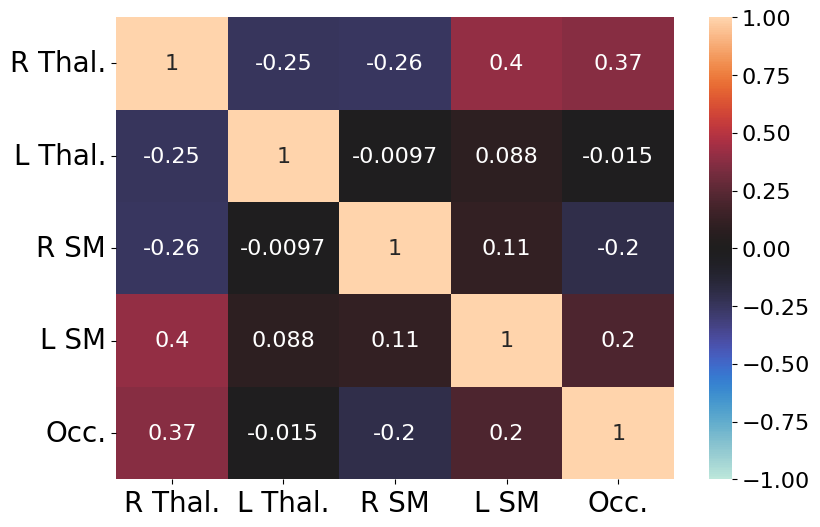

In [50]:
f, ax = plt.subplots(figsize=(9, 6), facecolor='none')

sns.heatmap(correlation_matrix, square=False, annot=True, 
            cmap='icefire', vmax=1, vmin=-1, annot_kws={"size": 16})
ax.set(xlabel='', ylabel='')

cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=16) # Adjust tick label font size

ax.set_xticklabels(voxel_labels)
ax.set_yticklabels(voxel_labels)

plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20, rotation = 0)

plt.savefig(save_dir + 'GABA_corr_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

## Global CV IKI vs. GABA


### Thalamus

In [11]:
# Pearson Correlation comparing Global CV IKI and R thal GABA
pearson_corr(dfs['indiv_globalmetrics'], 
                           'global', 
                           'none', 
                           'cv_IKI',
                           'R_thal')

cv_IKI global none vs. R_thal GABA
PearsonRResult(statistic=np.float64(0.12575367103970125), pvalue=np.float64(0.597304497238945))


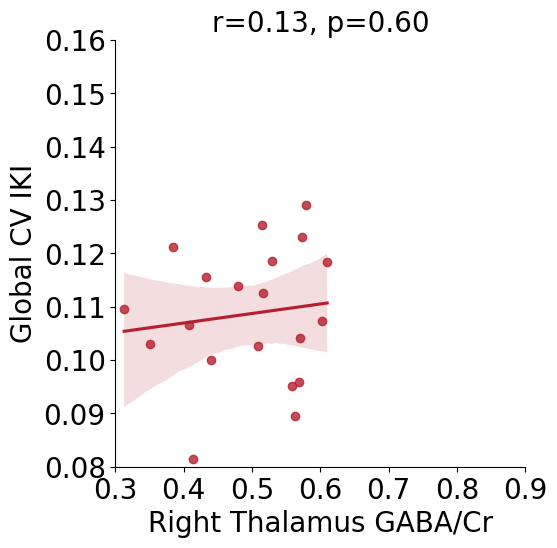

In [12]:
# Global CV IKI vs. R thal GABA
R_thal_data = task_vs_mrs_plot(dfs['indiv_globalmetrics'], 
                               'global', 
                               'none', 
                               'cv_IKI',
                               'R_thal')

R_thal_data = pd.concat([R_thal_data[0].reset_index(drop=True), 
                         R_thal_data[1].reset_index(drop=True)], axis = 1)

g = sns.lmplot(
    data=R_thal_data,
    x="cv_IKI", y="Mean_GABA_Cr",
    height=5,
    line_kws={'color': custom_RdBu[0]}, 
    scatter_kws={'color': custom_RdBu[0]}
)

g.set_axis_labels('Right Thalamus GABA/Cr', 'Global CV IKI', fontsize=20)

plt.ylim(0.08, 0.16)
plt.xlim(0.3, 0.85)

g.set_yticklabels(fontsize=20)
g.set_xticklabels(fontsize=20)

g.ax.set_title('r=0.13, p=0.60', fontsize=20)

# plt.xticks(fontsize=14)
# plt.yticks(fontsize=14)

plt.show()
g.savefig(save_dir + 'R_thal_cvIKI_corr.png', dpi=300, facecolor='none')

In [13]:
# Pearson Correlation comparing Global CV IKI and L thal GABA
pearson_corr(dfs['indiv_globalmetrics'], 
                           'global', 
                           'none', 
                           'cv_IKI',
                           'L_thal')

cv_IKI global none vs. L_thal GABA
PearsonRResult(statistic=np.float64(0.21231535682625427), pvalue=np.float64(0.3555021153213134))


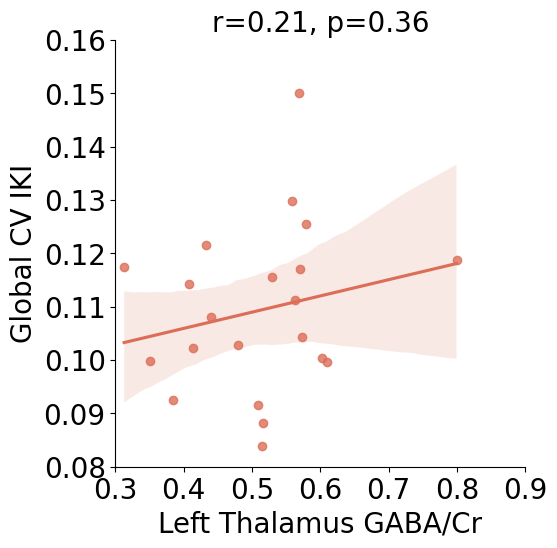

In [14]:
# Global CV IKI vs. L thal GABA
L_thal_data = task_vs_mrs_plot(dfs['indiv_globalmetrics'], 
                               'global', 
                               'none', 
                               'cv_IKI',
                               'L_thal')

L_thal_data = pd.concat([L_thal_data[0].reset_index(drop=True), 
                         L_thal_data[1].reset_index(drop=True)], axis = 1)

g = sns.lmplot(
    data=L_thal_data,
    x="cv_IKI", y="Mean_GABA_Cr",
    height=5,
    line_kws={'color': custom_RdBu[1]}, 
    scatter_kws={'color': custom_RdBu[1]}
)

g.set_axis_labels('Left Thalamus GABA/Cr', 'Global CV IKI', fontsize=20)

plt.ylim(0.08, 0.16)
plt.xlim(0.3, 0.85)

g.set_yticklabels(fontsize=20)
g.set_xticklabels(fontsize=20)

g.ax.set_title('r=0.21, p=0.36', fontsize=20)

# plt.xticks(fontsize=14)
# plt.yticks(fontsize=14)

plt.show()
g.savefig(save_dir + 'L_thal_cvIKI_corr.png', dpi=300, facecolor='none')

In [15]:
# ## High BF mean IKIs against L and R thalamus GABA
# R_data = task_vs_mrs_plot(dfs['indiv_globalmetrics'], 
#                                'global', 
#                                'none', 
#                                'cv_IKI',
#                                'R_thal')

# print('R:', np.mean(R_data[1]), np.std(R_data[1]))

# L_data = task_vs_mrs_plot(dfs['indiv_globalmetrics'], 
#                                'global', 
#                                'none', 
#                                'cv_IKI',
#                                'L_thal')

# print('L:', np.mean(L_data[1]), np.std(L_data[1]))

# plt.rc('text', color='black')
# plt.rc('axes', labelcolor='black')
# plt.rc('xtick', color='black')
# plt.rc('ytick', color='black')

# fig, ax = plt.subplots(figsize=(9, 6), facecolor='none')

# plt.scatter(R_data[1], R_data[0], s = 70, 
#                 color = 'red',
#                 label = 'Right')
# plt.scatter(L_data[1], L_data[0], s = 70, 
#                 color = 'blue',
#                 label = 'Left')

# plt.xlabel("R and L Thalamus GABA/Cr", fontsize = 30, labelpad=15)
# plt.ylabel("Global CV IKI (ms)", fontsize = 30, labelpad=15)
# plt.xticks(fontsize = 24, rotation = 45)
# plt.ylim(0.2, 0.9)
# plt.xlim(0.08, 0.16)
# plt.yticks(fontsize = 24)
# plt.title("")

# ax.set_facecolor('white')
# ax.spines['top'].set_visible(True)
# ax.spines['top'].set_color('black')
# ax.spines['bottom'].set_visible(True)
# ax.spines['bottom'].set_color('black')
# ax.spines['left'].set_visible(True)
# ax.spines['left'].set_color('black')
# ax.spines['right'].set_visible(True)
# ax.spines['right'].set_color('black')

# plt.legend(fontsize = 17, loc="lower right")

# fig.tight_layout()
# # fig, ax = plt.subplots(facecolor = 'aliceblue')
# plt.savefig(save_dir + 'RLthal_globalcv.png', dpi=300)
# plt.show()

### M1

In [16]:
# Pearson correlation comparing Global CV IKI and R M1 GABA
pearson_corr(dfs['indiv_globalmetrics'], 
                           'global', 
                           'none', 
                           'cv_IKI',
                           'R_M1')

cv_IKI global none vs. R_M1 GABA
PearsonRResult(statistic=np.float64(0.09887013240480848), pvalue=np.float64(0.6457784508833966))


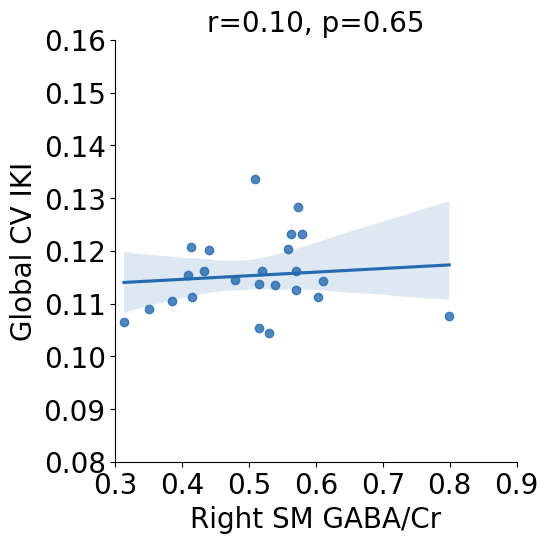

In [51]:
# Global CV IKI vs. R thal GABA
R_M1_data = task_vs_mrs_plot(dfs['indiv_globalmetrics'], 
                               'global', 
                               'none', 
                               'cv_IKI',
                               'R_M1')

R_M1_data = pd.concat([R_M1_data[0].reset_index(drop=True), 
                         R_M1_data[1].reset_index(drop=True)], axis = 1)

g = sns.lmplot(
    data=R_M1_data,
    x="cv_IKI", y="Mean_GABA_Cr",
    height=5,
    line_kws={'color': custom_RdBu[2]}, 
    scatter_kws={'color': custom_RdBu[2]}
)

g.set_axis_labels('Right SM GABA/Cr', 'Global CV IKI', fontsize=20)

plt.ylim(0.08, 0.16)
plt.xlim(0.3, 0.85)

g.set_yticklabels(fontsize=20)
g.set_xticklabels(fontsize=20)

g.ax.set_title('r=0.10, p=0.65', fontsize=20)

plt.show()
g.savefig(save_dir + 'R_M1_cvIKI_corr.png', dpi=300, facecolor='none')

In [18]:
# Pearson correlation comparing Global CV IKI and L M1 GABA
pearson_corr(dfs['indiv_globalmetrics'], 
                           'global', 
                           'none', 
                           'cv_IKI',
                           'L_M1')

cv_IKI global none vs. L_M1 GABA
PearsonRResult(statistic=np.float64(0.17494416232245757), pvalue=np.float64(0.413568827908905))


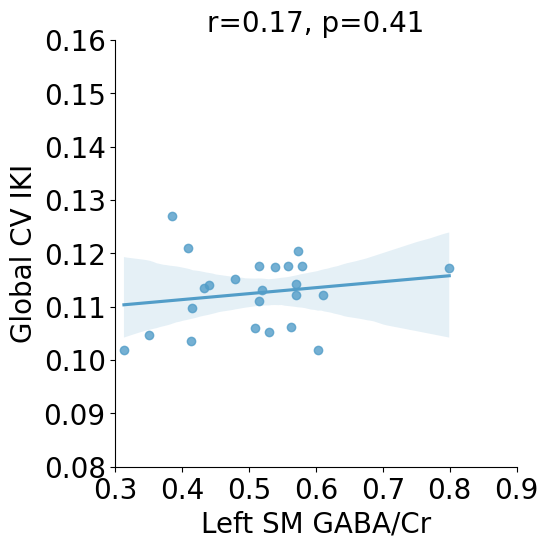

In [52]:
# Global CV IKI vs. L thal GABA
L_M1_data = task_vs_mrs_plot(dfs['indiv_globalmetrics'], 
                               'global', 
                               'none', 
                               'cv_IKI',
                               'L_M1')

L_M1_data = pd.concat([L_M1_data[0].reset_index(drop=True), 
                       L_M1_data[1].reset_index(drop=True)], axis = 1)

g = sns.lmplot(
    data=L_M1_data,
    x="cv_IKI", y="Mean_GABA_Cr",
    height=5,
    line_kws={'color': custom_RdBu[3]}, 
    scatter_kws={'color': custom_RdBu[3]}
)

g.set_axis_labels('Left SM GABA/Cr', 'Global CV IKI', fontsize=20)

plt.ylim(0.08, 0.16)
plt.xlim(0.3, 0.85)

g.set_yticklabels(fontsize=20)
g.set_xticklabels(fontsize=20)

g.ax.set_title('r=0.17, p=0.41', fontsize=20)

# plt.xticks(fontsize=14)
# plt.yticks(fontsize=14)

plt.show()
g.savefig(save_dir + 'L_M1_cvIKI_corr.png', dpi=300, facecolor='none')

In [20]:
# ## High BF mean IKIs against L and R thalamus GABA
# R_data = task_vs_mrs_plot(dfs['indiv_globalmetrics'], 
#                                'global', 
#                                'none', 
#                                'cv_IKI',
#                                'R_M1')

# print('R:', np.mean(R_data[1]), np.std(R_data[1]))

# L_data = task_vs_mrs_plot(dfs['indiv_globalmetrics'], 
#                                'global', 
#                                'none', 
#                                'cv_IKI',
#                                'L_M1')

# print('L:', np.mean(L_data[1]), np.std(L_data[1]))

# plt.rc('text', color='black')
# plt.rc('axes', labelcolor='black')
# plt.rc('xtick', color='black')
# plt.rc('ytick', color='black')

# fig, ax = plt.subplots(figsize=(9, 6), facecolor='none')

# plt.scatter(R_data[1], R_data[0], s = 70, 
#                 color = 'red',
#                 label = 'Right')
# plt.scatter(L_data[1], L_data[0], s = 70, 
#                 color = 'blue',
#                 label = 'Left')

# plt.xlabel("R and L M1 GABA/Cr", fontsize = 30, labelpad=15)
# plt.ylabel("Global CV IKI (ms)", fontsize = 30, labelpad=15)
# plt.xticks(fontsize = 24, rotation = 45)
# plt.ylim(0.2, 0.9)
# plt.xlim(0.08, 0.16)
# plt.yticks(fontsize = 24)
# plt.title("")

# ax.set_facecolor('white')
# ax.spines['top'].set_visible(True)
# ax.spines['top'].set_color('black')
# ax.spines['bottom'].set_visible(True)
# ax.spines['bottom'].set_color('black')
# ax.spines['left'].set_visible(True)
# ax.spines['left'].set_color('black')
# ax.spines['right'].set_visible(True)
# ax.spines['right'].set_color('black')

# plt.legend(fontsize = 17, loc="lower right")

# fig.tight_layout()
# # fig, ax = plt.subplots(facecolor = 'aliceblue')
# plt.savefig(save_dir + 'RLM1_globalcv.png', dpi=300)
# plt.show()

In [21]:
custom_RdBu

[(0.7118800461361015, 0.12179930795847752, 0.18169934640522878),
 (0.8622837370242215, 0.42952710495963087, 0.34271434063821604),
 (0.14248366013071895, 0.41730103806228375, 0.6833525567089581),
 (0.3234909650134564, 0.6149173394848135, 0.7854671280276817),
 (0.7137254901960784, 0.7137254901960784, 0.7137254901960784)]

### Occ

In [22]:
# Pearson correlation comparing Global CV IKI and Occ GABA
pearson_corr(dfs['indiv_globalmetrics'], 
                           'global', 
                           'none', 
                           'cv_IKI',
                           'occ')

cv_IKI global none vs. occ GABA
PearsonRResult(statistic=np.float64(0.09297131806829737), pvalue=np.float64(0.6730791583985877))


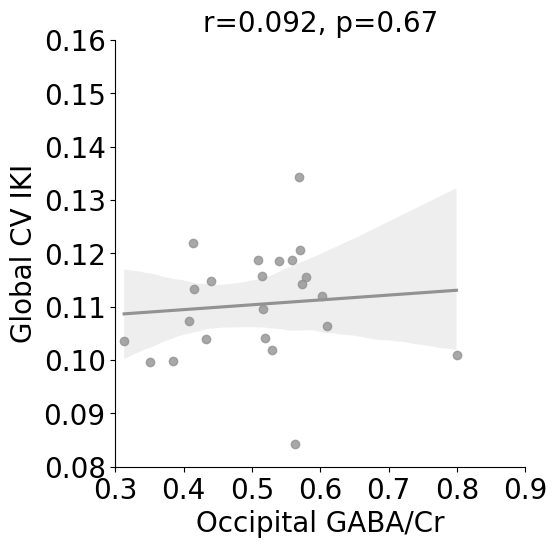

In [23]:
# Global CV IKI vs. L thal GABA
occ_data = task_vs_mrs_plot(dfs['indiv_globalmetrics'], 
                               'global', 
                               'none', 
                               'cv_IKI',
                               'occ')

occ_data = pd.concat([occ_data[0].reset_index(drop=True), 
                      occ_data[1].reset_index(drop=True)], axis = 1)

g = sns.lmplot(
    data=occ_data,
    x="cv_IKI", y="Mean_GABA_Cr",
    height=5,
    line_kws={'color': grey[3]}, 
    scatter_kws={'color': grey[3]}
)

g.set_axis_labels('Occipital GABA/Cr', 'Global CV IKI', fontsize=20)

plt.ylim(0.08, 0.16)
plt.xlim(0.3, 0.85)

g.set_yticklabels(fontsize=20)
g.set_xticklabels(fontsize=20)

g.ax.set_title('r=0.092, p=0.67', fontsize=20)

# plt.xticks(fontsize=14)
# plt.yticks(fontsize=14)

plt.show()
g.savefig(save_dir + 'occ_cvIKI_corr.png', dpi=300, facecolor='none')

## Global CV RT vs. GABA

### Thalamus

In [24]:
# Pearson Correlation comparing Global CV RT and R thal GABA
pearson_corr(dfs['indiv_globalmetrics'], 
                           'global', 
                           'none', 
                           'cv_RT',
                           'R_thal')

cv_RT global none vs. R_thal GABA
PearsonRResult(statistic=np.float64(-0.028854939867753338), pvalue=np.float64(0.9038821453883805))


In [25]:
# Pearson Correlation comparing Global CV RT and R thal GABA
pearson_corr(dfs['indiv_globalmetrics'], 
                           'global', 
                           'none', 
                           'cv_RT',
                           'R_M1')

cv_RT global none vs. R_M1 GABA
PearsonRResult(statistic=np.float64(-0.21853484518842847), pvalue=np.float64(0.30493255176051615))


In [26]:
# Pearson Correlation comparing Global CV RT and R thal GABA
pearson_corr(dfs['indiv_globalmetrics'], 
                           'global', 
                           'none', 
                           'cv_RT',
                           'L_M1')

cv_RT global none vs. L_M1 GABA
PearsonRResult(statistic=np.float64(0.33726661537338026), pvalue=np.float64(0.10702997095765057))


In [27]:
# Pearson Correlation comparing Global CV RT and R thal GABA
pearson_corr(dfs['indiv_globalmetrics'], 
                           'global', 
                           'none', 
                           'cv_RT',
                           'occ')

cv_RT global none vs. occ GABA
PearsonRResult(statistic=np.float64(0.08011352267576315), pvalue=np.float64(0.7163286735267029))


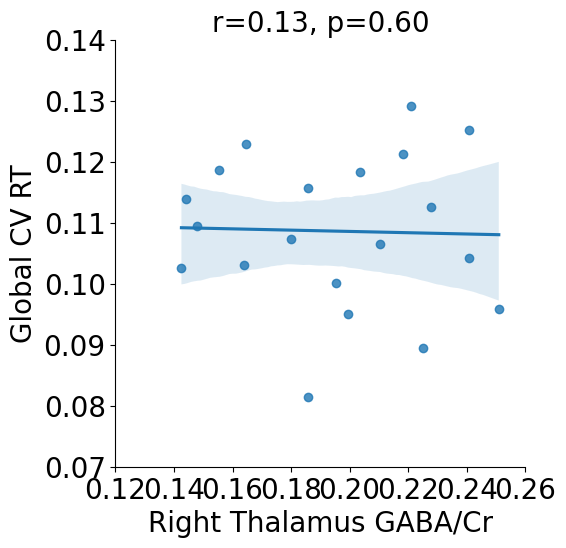

In [28]:
# Global CV IKI vs. R thal GABA
R_thal_data = task_vs_mrs_plot(dfs['indiv_globalmetrics'], 
                               'global', 
                               'none', 
                               'cv_RT',
                               'R_thal')

R_thal_data = pd.concat([R_thal_data[0].reset_index(drop=True), 
                         R_thal_data[1].reset_index(drop=True)], axis = 1)

g = sns.lmplot(
    data=R_thal_data,
    x="cv_RT", y="Mean_GABA_Cr",
    height=5
)

g.set_axis_labels('Right Thalamus GABA/Cr', 'Global CV RT', fontsize=20)

# plt.ylim(0.08, 0.16)
# plt.xlim(0.3, 0.85)

g.set_yticklabels(fontsize=20)
g.set_xticklabels(fontsize=20)

g.ax.set_title('r=0.13, p=0.60', fontsize=20)

# plt.xticks(fontsize=14)
# plt.yticks(fontsize=14)

plt.show()
g.savefig(save_dir + 'R_thal_cvIKI_corr.png', dpi=300, facecolor='none')

In [29]:
# Pearson Correlation comparing Global CV RT and R thal GABA
pearson_corr(dfs['indiv_globalmetrics'], 
                           'global', 
                           'none', 
                           'cv_RT',
                           'L_thal')

cv_RT global none vs. L_thal GABA
PearsonRResult(statistic=np.float64(0.24578000836995303), pvalue=np.float64(0.2828584364507161))


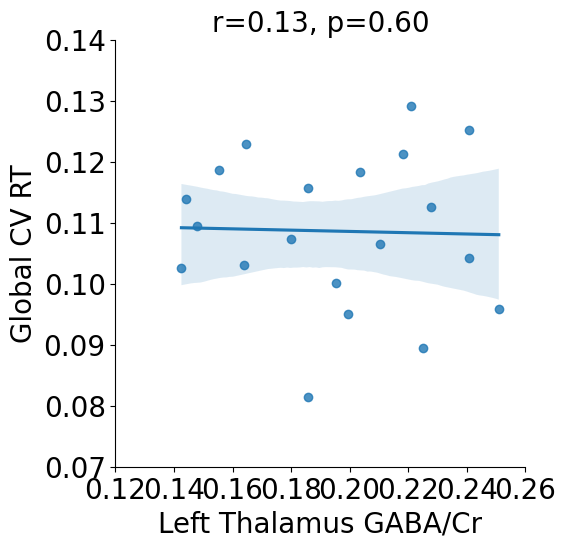

In [30]:
# Global CV IKI vs. R thal GABA
L_thal_data = task_vs_mrs_plot(dfs['indiv_globalmetrics'], 
                               'global', 
                               'none', 
                               'cv_RT',
                               'L_thal')

L_thal_data = pd.concat([L_thal_data[0].reset_index(drop=True), 
                         L_thal_data[1].reset_index(drop=True)], axis = 1)

g = sns.lmplot(
    data=R_thal_data,
    x="cv_RT", y="Mean_GABA_Cr",
    height=5
)

g.set_axis_labels('Left Thalamus GABA/Cr', 'Global CV RT', fontsize=20)

# plt.ylim(0.08, 0.16)
# plt.xlim(0.3, 0.85)

g.set_yticklabels(fontsize=20)
g.set_xticklabels(fontsize=20)

g.ax.set_title('r=0.13, p=0.60', fontsize=20)

# plt.xticks(fontsize=14)
# plt.yticks(fontsize=14)

plt.show()
g.savefig(save_dir + 'L_thal_cvIKI_corr.png', dpi=300, facecolor='none')

# Thalamus Correlations

In [31]:
# Bigram freq. task metrics vs. R and L Thalamic GABA/Cr

pearson_corr(dfs['iki_metrics_bybf'], 
                           'bf_type', 
                           'high', 
                           'mean_IKI',
                           'R_thal')

pearson_corr(dfs['iki_metrics_bybf'], 
                           'bf_type', 
                           'high', 
                           'mean_IKI',
                           'L_thal')

pearson_corr(dfs['iki_metrics_bybf'], 
                           'bf_type', 
                           'high', 
                           'sd_IKI',
                           'R_thal')

pearson_corr(dfs['iki_metrics_bybf'], 
                           'bf_type', 
                           'high', 
                           'sd_IKI',
                           'L_thal')

pearson_corr(dfs['iki_metrics_bybf'], 
                           'bf_type', 
                           'high', 
                           'cv_IKI',
                           'R_thal')

pearson_corr(dfs['iki_metrics_bybf'], 
                           'bf_type', 
                           'high', 
                           'cv_IKI',
                           'L_thal')

pearson_corr(dfs['delta_ikis_bybf'], 
                           'bf_type', 
                           'high', 
                           'mean_deltaiki',
                           'R_thal')

pearson_corr(dfs['delta_ikis_bybf'], 
                           'bf_type', 
                           'high', 
                           'mean_deltaiki',
                           'L_thal')

mean_IKI bf_type high vs. R_thal GABA
PearsonRResult(statistic=np.float64(0.0802827630134081), pvalue=np.float64(0.7365232149374721))
mean_IKI bf_type high vs. L_thal GABA
PearsonRResult(statistic=np.float64(-0.003402492973442602), pvalue=np.float64(0.9883214726514475))
sd_IKI bf_type high vs. R_thal GABA
PearsonRResult(statistic=np.float64(0.10659123912730947), pvalue=np.float64(0.6546767238809053))
sd_IKI bf_type high vs. L_thal GABA
PearsonRResult(statistic=np.float64(0.2068194035242092), pvalue=np.float64(0.3683802193341113))
cv_IKI bf_type high vs. R_thal GABA
PearsonRResult(statistic=np.float64(0.1563966043087256), pvalue=np.float64(0.5102412807703218))
cv_IKI bf_type high vs. L_thal GABA
PearsonRResult(statistic=np.float64(0.33966371662193523), pvalue=np.float64(0.13195784026615542))
mean_deltaiki bf_type high vs. R_thal GABA
PearsonRResult(statistic=np.float64(-0.06106102209276477), pvalue=np.float64(0.7981605852563496))
mean_deltaiki bf_type high vs. L_thal GABA
PearsonRResult

In [32]:
def delta_var_corr(df, voxel, sd_or_cv):
    mrs = GABA_quant[(GABA_quant['voxel'] == voxel) & 
                     (GABA_quant['Mean_GABA_Cr'].isna() == False)]
    sIDs = mrs.sID.unique()
    delta_vars = df[df['sID'].isin(sIDs)].reset_index(drop=True)
    print(pearsonr(delta_vars[sd_or_cv], mrs['Mean_GABA_Cr']))

delta_var_corr(dfs['delta_vars_bybf'], 'R_thal', 'sd_diff')
delta_var_corr(dfs['delta_vars_bybf'], 'L_thal', 'sd_diff')

delta_var_corr(dfs['delta_vars_bybf'], 'R_thal', 'cv_diff')
delta_var_corr(dfs['delta_vars_bybf'], 'L_thal', 'cv_diff')

PearsonRResult(statistic=np.float64(0.1163360586165003), pvalue=np.float64(0.6252418548704775))
PearsonRResult(statistic=np.float64(-0.057237266198623196), pvalue=np.float64(0.8053458184101858))
PearsonRResult(statistic=np.float64(0.20339735959944483), pvalue=np.float64(0.3897374260904811))
PearsonRResult(statistic=np.float64(0.19578853108394323), pvalue=np.float64(0.39501771443195755))


In [33]:
# Word freq. task metrics vs. R and L Thalamic GABA/Cr

pearson_corr(dfs['iki_metrics_bywf'], 
                           'wf_type', 
                           'high', 
                           'mean_IKI',
                           'R_thal')

pearson_corr(dfs['iki_metrics_bywf'], 
                           'wf_type', 
                           'high', 
                           'mean_IKI',
                           'L_thal')

pearson_corr(dfs['iki_metrics_bywf'], 
                           'wf_type', 
                           'high', 
                           'sd_IKI',
                           'R_thal')

pearson_corr(dfs['iki_metrics_bywf'], 
                           'wf_type', 
                           'high', 
                           'sd_IKI',
                           'L_thal')

pearson_corr(dfs['iki_metrics_bywf'], 
                           'wf_type', 
                           'high', 
                           'cv_IKI',
                           'R_thal')

pearson_corr(dfs['iki_metrics_bywf'], 
                           'wf_type', 
                           'high', 
                           'cv_IKI',
                           'L_thal')

pearson_corr(dfs['delta_ikis_bywf'], 
                           'wf_type', 
                           'high', 
                           'mean_deltaiki',
                           'R_thal')

pearson_corr(dfs['delta_ikis_bywf'], 
                           'wf_type', 
                           'high', 
                           'mean_deltaiki',
                           'L_thal')


delta_var_corr(dfs['delta_vars_bywf'], 'R_thal', 'sd_diff')
delta_var_corr(dfs['delta_vars_bywf'], 'L_thal', 'sd_diff')

delta_var_corr(dfs['delta_vars_bywf'], 'R_thal', 'cv_diff')
delta_var_corr(dfs['delta_vars_bywf'], 'L_thal', 'cv_diff')

mean_IKI wf_type high vs. R_thal GABA
PearsonRResult(statistic=np.float64(0.12230359871997666), pvalue=np.float64(0.6074789551566506))
mean_IKI wf_type high vs. L_thal GABA
PearsonRResult(statistic=np.float64(-0.04304288370722724), pvalue=np.float64(0.8530294786575976))
sd_IKI wf_type high vs. R_thal GABA
PearsonRResult(statistic=np.float64(-0.032352735152660926), pvalue=np.float64(0.8922921613489931))
sd_IKI wf_type high vs. L_thal GABA
PearsonRResult(statistic=np.float64(-0.08922407465537457), pvalue=np.float64(0.7005279323987609))
cv_IKI wf_type high vs. R_thal GABA
PearsonRResult(statistic=np.float64(-0.10373159694682504), pvalue=np.float64(0.6634108717443968))
cv_IKI wf_type high vs. L_thal GABA
PearsonRResult(statistic=np.float64(-0.05289687226608659), pvalue=np.float64(0.8198641809058352))
mean_deltaiki wf_type high vs. R_thal GABA
PearsonRResult(statistic=np.float64(0.09455025006939852), pvalue=np.float64(0.6917322642190018))
mean_deltaiki wf_type high vs. L_thal GABA
PearsonRR

### Thalamus figures

In [34]:
R_data = task_vs_mrs_plot(dfs['iki_metrics_bywf'], 
                               'wf_type', 
                               'high', 
                               'mean_IKI',
                               'R_thal')
R_data[0]

5     170.152453
10    126.578036
14    138.077255
17    128.616867
20    153.483016
34    238.835535
39    225.569414
41    147.509330
46    116.426333
49    126.348889
54    161.936017
58    172.688542
66    222.838209
70    109.994354
75    144.237646
76    169.180431
83    153.003915
85    146.782866
89    172.783875
95    155.690459
Name: mean_IKI, dtype: float64

In [35]:
# ## High BF mean IKIs against L and R thalamus GABA
# R_data = task_vs_mrs_plot(dfs['iki_metrics_bywf'], 
#                                'wf_type', 
#                                'high', 
#                                'mean_IKI',
#                                'R_thal')

# print('R:', np.mean(R_data[1]), np.std(R_data[1]))

# L_data = task_vs_mrs_plot(dfs['iki_metrics_bywf'], 
#                                'wf_type', 
#                                'high', 
#                                'mean_IKI',
#                                'L_thal')

# print('L:', np.mean(L_data[1]), np.std(L_data[1]))

# plt.rc('text', color='white')
# plt.rc('axes', labelcolor='white')
# plt.rc('xtick', color='white')
# plt.rc('ytick', color='white')

# fig, ax = plt.subplots(figsize=(9, 6), facecolor='none')

# plt.scatter(R_data[1], R_data[0], s = 70, 
#                 color = 'red',
#                 label = 'Right')
# plt.scatter(L_data[1], L_data[0], s = 70, 
#                 color = 'blue',
#                 label = 'Left')

# plt.xlabel("R and L Thalamus GABA/Cr", fontsize = 30, labelpad=15)
# plt.ylabel("Mean IKI - High BF (ms)", fontsize = 30, labelpad=15)
# plt.xticks(fontsize = 24, rotation = 45)
# # plt.ylim(0.04, 0.08)
# # plt.xlim(0.085, 0.125)
# plt.yticks(fontsize = 24)
# plt.title("")

# ax.set_facecolor('black')
# ax.spines['top'].set_visible(True)
# ax.spines['top'].set_color('white')
# ax.spines['bottom'].set_visible(True)
# ax.spines['bottom'].set_color('white')
# ax.spines['left'].set_visible(True)
# ax.spines['left'].set_color('white')
# ax.spines['right'].set_visible(True)
# ax.spines['right'].set_color('white')

# plt.legend(fontsize = 17, loc="lower right")

# fig.tight_layout()
# # fig, ax = plt.subplots(facecolor = 'aliceblue')
# plt.savefig(save_dir + 'RLthal_allbfsd.png', dpi=300)
# plt.show()

In [36]:
# ## High BF SD IKIs against L and R thalamus GABA
# R_data = task_vs_mrs_plot(dfs['iki_metrics_bywf'], 
#                                'wf_type', 
#                                'high', 
#                                'sd_IKI',
#                                'R_thal')

# L_data = task_vs_mrs_plot(dfs['iki_metrics_bywf'], 
#                                'wf_type', 
#                                'high', 
#                                'sd_IKI',
#                                'L_thal')

# plt.rc('text', color='black')
# plt.rc('axes', labelcolor='black')
# plt.rc('xtick', color='black')
# plt.rc('ytick', color='black')

# fig, ax = plt.subplots(figsize=(9, 6), facecolor='none')

# plt.scatter(R_data[1], R_data[0], s = 70, 
#                 color = 'red',
#                 label = 'Right')
# plt.scatter(L_data[1], L_data[0], s = 70, 
#                 color = 'blue',
#                 label = 'Left')

# plt.xlabel("R and L Thalamus GABA/Cr", fontsize = 30, labelpad=15)
# plt.ylabel("SD IKI - High BF (ms)", fontsize = 30, labelpad=15)
# plt.xticks(fontsize = 24, rotation = 45)
# # plt.ylim(20, 120)
# # plt.xlim(0.085, 0.135)
# plt.yticks(fontsize = 24)
# plt.title("")

# ax.set_facecolor('white')
# ax.spines['top'].set_visible(True)
# ax.spines['top'].set_color('black')
# ax.spines['bottom'].set_visible(True)
# ax.spines['bottom'].set_color('black')
# ax.spines['left'].set_visible(True)
# ax.spines['left'].set_color('black')
# ax.spines['right'].set_visible(True)
# ax.spines['right'].set_color('black')

# plt.legend(fontsize = 17, loc="lower right")

# fig.tight_layout()
# # fig, ax = plt.subplots(facecolor = 'aliceblue')
# plt.savefig(save_dir + 'RLthal_sd_highbf.png', dpi=300)
# plt.show()

In [37]:
# ## High BF SD IKIs against L and R thalamus GABA
# R_data = task_vs_mrs_plot(dfs['iki_metrics_bywf'], 
#                                'wf_type', 
#                                'high', 
#                                'cv_IKI',
#                                'R_thal')

# L_data = task_vs_mrs_plot(dfs['iki_metrics_bywf'], 
#                                'wf_type', 
#                                'high', 
#                                'cv_IKI',
#                                'L_thal')

# plt.rc('text', color='white')
# plt.rc('axes', labelcolor='white')
# plt.rc('xtick', color='white')
# plt.rc('ytick', color='white')

# fig, ax = plt.subplots(figsize=(9, 6), facecolor='none')

# plt.scatter(R_data[1], R_data[0], s = 70, 
#                 color = 'red',
#                 label = 'Right')
# plt.scatter(L_data[1], L_data[0], s = 70, 
#                 color = 'blue',
#                 label = 'Left')

# plt.xlabel("R and L Thalamus GABA/Cr", fontsize = 30, labelpad=15)
# plt.ylabel("Mean IKI (all Bigram Freqs.)", fontsize = 30, labelpad=15)
# plt.xticks(fontsize = 24, rotation = 45)
# # plt.ylim(0.04, 0.08)
# # plt.xlim(0.085, 0.125)
# plt.yticks(fontsize = 24)
# plt.title("")

# ax.set_facecolor('black')
# ax.spines['top'].set_visible(True)
# ax.spines['top'].set_color('white')
# ax.spines['bottom'].set_visible(True)
# ax.spines['bottom'].set_color('white')
# ax.spines['left'].set_visible(True)
# ax.spines['left'].set_color('white')
# ax.spines['right'].set_visible(True)
# ax.spines['right'].set_color('white')

# plt.legend(fontsize = 17, loc="lower right")

# fig.tight_layout()
# # fig, ax = plt.subplots(facecolor = 'aliceblue')
# plt.savefig(save_dir + 'RLthal_allbfsd.png', dpi=300)
# plt.show()

# M1 Correlations

In [38]:
# Bigram freq. task metrics vs. R and L M1 GABA/Cr

pearson_corr(dfs['iki_metrics_bybf'], 
                           'bf_type', 
                           'high', 
                           'mean_IKI',
                           'R_M1')

pearson_corr(dfs['iki_metrics_bybf'], 
                           'bf_type', 
                           'high', 
                           'mean_IKI',
                           'L_M1')

pearson_corr(dfs['iki_metrics_bybf'], 
                           'bf_type', 
                           'high', 
                           'sd_IKI',
                           'R_M1')

pearson_corr(dfs['iki_metrics_bybf'], 
                           'bf_type', 
                           'high', 
                           'sd_IKI',
                           'L_M1')

pearson_corr(dfs['iki_metrics_bybf'], 
                           'bf_type', 
                           'high', 
                           'cv_IKI',
                           'R_M1')

pearson_corr(dfs['iki_metrics_bybf'], 
                           'bf_type', 
                           'high', 
                           'cv_IKI',
                           'L_M1')

pearson_corr(dfs['delta_ikis_bybf'], 
                           'bf_type', 
                           'high', 
                           'mean_deltaiki',
                           'R_M1')

pearson_corr(dfs['delta_ikis_bybf'], 
                           'bf_type', 
                           'high', 
                           'mean_deltaiki',
                           'L_M1')

delta_var_corr(dfs['delta_vars_bybf'], 'R_M1', 'sd_diff')
delta_var_corr(dfs['delta_vars_bybf'], 'L_M1', 'sd_diff')

delta_var_corr(dfs['delta_vars_bybf'], 'R_M1', 'cv_diff')
delta_var_corr(dfs['delta_vars_bybf'], 'L_M1', 'cv_diff')

mean_IKI bf_type high vs. R_M1 GABA
PearsonRResult(statistic=np.float64(-0.2064099129479673), pvalue=np.float64(0.3331986220948293))
mean_IKI bf_type high vs. L_M1 GABA
PearsonRResult(statistic=np.float64(-0.10246032370236365), pvalue=np.float64(0.6337807509124123))
sd_IKI bf_type high vs. R_M1 GABA
PearsonRResult(statistic=np.float64(-0.007080133819356335), pvalue=np.float64(0.9738069040146511))
sd_IKI bf_type high vs. L_M1 GABA
PearsonRResult(statistic=np.float64(0.1201166377170147), pvalue=np.float64(0.5761166200421762))
cv_IKI bf_type high vs. R_M1 GABA
PearsonRResult(statistic=np.float64(0.14050769468640775), pvalue=np.float64(0.5125586283690416))
cv_IKI bf_type high vs. L_M1 GABA
PearsonRResult(statistic=np.float64(0.2586618775983888), pvalue=np.float64(0.22230001470038438))
mean_deltaiki bf_type high vs. R_M1 GABA
PearsonRResult(statistic=np.float64(0.18665809985170473), pvalue=np.float64(0.38248304780105646))
mean_deltaiki bf_type high vs. L_M1 GABA
PearsonRResult(statistic=np.

In [39]:
# Word freq. task metrics vs. R and L M1 GABA/Cr

pearson_corr(dfs['iki_metrics_bywf'], 
                           'wf_type', 
                           'high', 
                           'mean_IKI',
                           'R_M1')

pearson_corr(dfs['iki_metrics_bywf'], 
                           'wf_type', 
                           'high', 
                           'mean_IKI',
                           'L_M1')

pearson_corr(dfs['iki_metrics_bywf'], 
                           'wf_type', 
                           'high', 
                           'sd_IKI',
                           'R_M1')

pearson_corr(dfs['iki_metrics_bywf'], 
                           'wf_type', 
                           'high', 
                           'sd_IKI',
                           'L_M1')

pearson_corr(dfs['iki_metrics_bywf'], 
                           'wf_type', 
                           'high', 
                           'cv_IKI',
                           'R_M1')

pearson_corr(dfs['iki_metrics_bywf'], 
                           'wf_type', 
                           'high', 
                           'cv_IKI',
                           'L_M1')

pearson_corr(dfs['delta_ikis_bywf'], 
                           'wf_type', 
                           'high', 
                           'mean_deltaiki',
                           'R_M1')

pearson_corr(dfs['delta_ikis_bywf'], 
                           'wf_type', 
                           'high', 
                           'mean_deltaiki',
                           'L_M1')

delta_var_corr(dfs['delta_vars_bywf'], 'R_M1', 'sd_diff')
delta_var_corr(dfs['delta_vars_bywf'], 'L_M1', 'sd_diff')

delta_var_corr(dfs['delta_vars_bywf'], 'R_M1', 'cv_diff')
delta_var_corr(dfs['delta_vars_bywf'], 'L_M1', 'cv_diff')

mean_IKI wf_type high vs. R_M1 GABA
PearsonRResult(statistic=np.float64(-0.07113056341630795), pvalue=np.float64(0.7411858340465365))
mean_IKI wf_type high vs. L_M1 GABA
PearsonRResult(statistic=np.float64(-0.08250370346135634), pvalue=np.float64(0.7015257901832589))
sd_IKI wf_type high vs. R_M1 GABA
PearsonRResult(statistic=np.float64(0.20238891507467416), pvalue=np.float64(0.3429083433073773))
sd_IKI wf_type high vs. L_M1 GABA
PearsonRResult(statistic=np.float64(0.09264393471341512), pvalue=np.float64(0.6667883081266601))
cv_IKI wf_type high vs. R_M1 GABA
PearsonRResult(statistic=np.float64(0.3608867789978406), pvalue=np.float64(0.08317881219570075))
cv_IKI wf_type high vs. L_M1 GABA
PearsonRResult(statistic=np.float64(0.18058319846279677), pvalue=np.float64(0.3984343987095437))
mean_deltaiki wf_type high vs. R_M1 GABA
PearsonRResult(statistic=np.float64(-0.09250477057434163), pvalue=np.float64(0.6672607689243945))
mean_deltaiki wf_type high vs. L_M1 GABA
PearsonRResult(statistic=np.

### M1 figures

In [40]:
# ## High BF mean IKIs against L and R M1 GABA
# R_data = task_vs_mrs_plot(dfs['iki_metrics_bywf'], 
#                                'wf_type', 
#                                'high', 
#                                'mean_IKI',
#                                'R_M1')

# L_data = task_vs_mrs_plot(dfs['iki_metrics_bywf'], 
#                                'wf_type', 
#                                'high', 
#                                'mean_IKI',
#                                'L_M1')

# print('R:', np.mean(R_data[1]), np.std(R_data[1]))
# print('L:', np.mean(L_data[1]), np.std(L_data[1]))
# print(len(R_data[0]))

# plt.rc('text', color='white')
# plt.rc('axes', labelcolor='white')
# plt.rc('xtick', color='white')
# plt.rc('ytick', color='white')

# fig, ax = plt.subplots(figsize=(9, 6), facecolor='none')

# plt.scatter(R_data[1], R_data[0], s = 70, 
#                 color = 'red',
#                 label = 'Right')
# plt.scatter(L_data[1], L_data[0], s = 70, 
#                 color = 'blue',
#                 label = 'Left')

# plt.xlabel("R and L M1 GABA/Cr", fontsize = 30, labelpad=15)
# plt.ylabel("Mean IKI - High BF (ms)", fontsize = 30, labelpad=15)
# plt.xticks(fontsize = 24, rotation = 45)
# # plt.ylim(0.04, 0.08)
# # plt.xlim(0.085, 0.125)
# plt.yticks(fontsize = 24)
# plt.title("")

# ax.set_facecolor('black')
# ax.spines['top'].set_visible(True)
# ax.spines['top'].set_color('white')
# ax.spines['bottom'].set_visible(True)
# ax.spines['bottom'].set_color('white')
# ax.spines['left'].set_visible(True)
# ax.spines['left'].set_color('white')
# ax.spines['right'].set_visible(True)
# ax.spines['right'].set_color('white')

# plt.legend(fontsize = 17, loc="lower right")

# fig.tight_layout()
# # fig, ax = plt.subplots(facecolor = 'aliceblue')
# plt.savefig(save_dir + 'RLthal_allbfsd.png', dpi=300)
# plt.show()

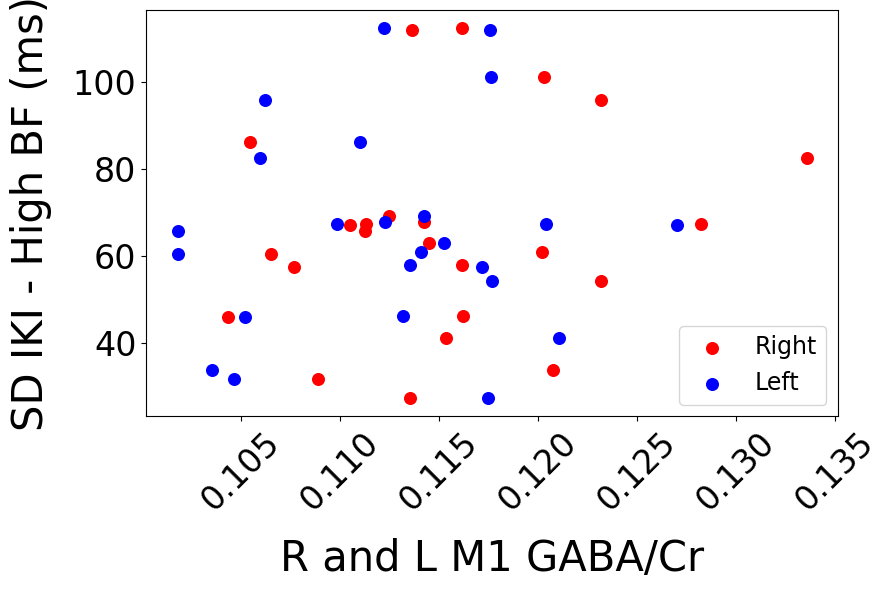

In [41]:
## High BF SD IKIs against L and R M1 GABA
R_data = task_vs_mrs_plot(dfs['iki_metrics_bywf'], 
                               'wf_type', 
                               'high', 
                               'sd_IKI',
                               'R_M1')

L_data = task_vs_mrs_plot(dfs['iki_metrics_bywf'], 
                               'wf_type', 
                               'high', 
                               'sd_IKI',
                               'L_M1')

plt.rc('text', color='black')
plt.rc('axes', labelcolor='black')
plt.rc('xtick', color='black')
plt.rc('ytick', color='black')

fig, ax = plt.subplots(figsize=(9, 6), facecolor='none')

plt.scatter(R_data[1], R_data[0], s = 70, 
                color = 'red',
                label = 'Right')
plt.scatter(L_data[1], L_data[0], s = 70, 
                color = 'blue',
                label = 'Left')

plt.xlabel("R and L M1 GABA/Cr", fontsize = 30, labelpad=15)
plt.ylabel("SD IKI - High BF (ms)", fontsize = 30, labelpad=15)
plt.xticks(fontsize = 24, rotation = 45)
# plt.ylim(20, 120)
# plt.xlim(0.085, 0.135)
plt.yticks(fontsize = 24)
plt.title("")

ax.set_facecolor('white')
ax.spines['top'].set_visible(True)
ax.spines['top'].set_color('black')
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_visible(True)
ax.spines['left'].set_color('black')
ax.spines['right'].set_visible(True)
ax.spines['right'].set_color('black')

plt.legend(fontsize = 17, loc="lower right")

fig.tight_layout()
# fig, ax = plt.subplots(facecolor = 'aliceblue')
plt.savefig(save_dir + 'RLthal_sd_highbf.png', dpi=300)
plt.show()

In [42]:
# ## High BF CV IKIs against L and R M1 GABA
# R_data = task_vs_mrs_plot(dfs['iki_metrics_bywf'], 
#                                'wf_type', 
#                                'high', 
#                                'cv_IKI',
#                                'R_M1')

# L_data = task_vs_mrs_plot(dfs['iki_metrics_bywf'], 
#                                'wf_type', 
#                                'high', 
#                                'cv_IKI',
#                                'L_M1')

# plt.rc('text', color='white')
# plt.rc('axes', labelcolor='white')
# plt.rc('xtick', color='white')
# plt.rc('ytick', color='white')

# fig, ax = plt.subplots(figsize=(9, 6), facecolor='none')

# plt.scatter(R_data[1], R_data[0], s = 70, 
#                 color = 'red',
#                 label = 'Right')
# plt.scatter(L_data[1], L_data[0], s = 70, 
#                 color = 'blue',
#                 label = 'Left')

# plt.xlabel("R and L M1 GABA/Cr", fontsize = 30, labelpad=15)
# plt.ylabel("CV IKI - High BF (ms)", fontsize = 30, labelpad=15)
# plt.xticks(fontsize = 24, rotation = 45)
# # plt.ylim(0.04, 0.08)
# # plt.xlim(0.085, 0.125)
# plt.yticks(fontsize = 24)
# plt.title("")

# ax.set_facecolor('black')
# ax.spines['top'].set_visible(True)
# ax.spines['top'].set_color('white')
# ax.spines['bottom'].set_visible(True)
# ax.spines['bottom'].set_color('white')
# ax.spines['left'].set_visible(True)
# ax.spines['left'].set_color('white')
# ax.spines['right'].set_visible(True)
# ax.spines['right'].set_color('white')

# plt.legend(fontsize = 17, loc="lower right")

# fig.tight_layout()
# # fig, ax = plt.subplots(facecolor = 'aliceblue')
# plt.savefig(save_dir + 'RLthal_allbfsd.png', dpi=300)
# plt.show()

# Occipital Correlations

In [43]:
occ_sIDs = GABA_quant[GABA_quant['voxel'] == 'occ'].dropna().sID.unique()
occ = GABA_quant[GABA_quant['voxel'] == 'occ']['Mean_GABA_Cr']

print('M1 v. High BF Mean IKI')
R_meaniki_bf = pearson_filter(dfs['iki_metrics_bybf'], 
                           'bf_type', 
                           'high', 
                           'mean_IKI',
                           occ_sIDs)
print(pearsonr(R_meaniki_bf, occ))

print('M1 v. High BF SD IKI')
R_sdiki_bf = pearson_filter(dfs['iki_metrics_bybf'], 
                           'bf_type', 
                           'high', 
                           'sd_IKI',
                           occ_sIDs)
print(pearsonr(R_sdiki_bf, occ))

print('GABA v. High BF CV IKI')
R_cviki_bf = pearson_filter(dfs['iki_metrics_bybf'], 
                           'bf_type', 
                           'high', 
                           'cv_IKI',
                           occ_sIDs)
print(pearsonr(R_cviki_bf, occ))

print('GABA v. High BF Delta IKI')
R_deltaiki_bf = pearson_filter(dfs['delta_ikis_bybf'], 
                           'bf_type', 
                           'high', 
                           'mean_deltaiki',
                           occ_sIDs)
print(pearsonr(R_deltaiki_bf, occ))

M1 v. High BF Mean IKI


TypeError: unsupported operand type(s) for +: 'float' and 'str'

In [ ]:
# Bigram freq. task metrics vs. Occipital GABA/Cr

pearson_corr(dfs['iki_metrics_bybf'], 
                           'bf_type', 
                           'high', 
                           'mean_IKI',
                           'occ')

pearson_corr(dfs['iki_metrics_bybf'], 
                           'bf_type', 
                           'high', 
                           'sd_IKI',
                           'occ')

pearson_corr(dfs['iki_metrics_bybf'], 
                           'bf_type', 
                           'high', 
                           'cv_IKI',
                           'occ')

pearson_corr(dfs['delta_ikis_bybf'], 
                           'bf_type', 
                           'high', 
                           'mean_deltaiki',
                           'occ')

delta_var_corr(dfs['delta_vars_bybf'], 'occ', 'sd_diff')

delta_var_corr(dfs['delta_vars_bybf'], 'occ', 'cv_diff')

In [ ]:
# Word freq. task metrics vs. R and L Thalamic GABA/Cr

pearson_corr(dfs['iki_metrics_bywf'], 
                           'wf_type', 
                           'high', 
                           'mean_IKI',
                           'occ')

pearson_corr(dfs['iki_metrics_bywf'], 
                           'wf_type', 
                           'high', 
                           'sd_IKI',
                           'occ')

pearson_corr(dfs['iki_metrics_bywf'], 
                           'wf_type', 
                           'high', 
                           'cv_IKI',
                           'occ')

pearson_corr(dfs['delta_ikis_bywf'], 
                           'wf_type', 
                           'high', 
                           'mean_deltaiki',
                           'occ')

delta_var_corr(dfs['delta_vars_bywf'], 'occ', 'sd_diff')

delta_var_corr(dfs['delta_vars_bywf'], 'occ', 'cv_diff')